<a href="https://colab.research.google.com/github/FranciscoRMendes/tensor-rank/blob/main/CNN_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install calflops
# !pip install tensorly
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 import copy
PATH = './cifar_net.pth'

100%|██████████| 170498071/170498071 [00:04<00:00, 39748541.55it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


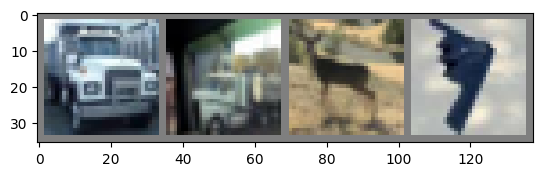

truck truck deer  plane


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
#
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
#
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Start with a simple CNN for the CIFAR data set. This performs decently well, we will focus on optimizing the size with a relatively small loss in performance.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers  = nn.ModuleDict()
        self.layers['conv1'] = nn.Conv2d(3, 6, 5)
        self.layers['pool'] = nn.MaxPool2d(2, 2)
        self.layers['conv2'] = nn.Conv2d(6, 16, 5)
        self.layers['fc1'] = nn.Linear(16 * 5 * 5, 120)
        self.layers['fc2'] = nn.Linear(120, 84)
        self.layers['fc3'] = nn.Linear(84, 10)

    def forward(self,x):
        x = self.layers['pool'](F.relu(self.layers['conv1'](x)))
        x = self.layers['pool'](F.relu(self.layers['conv2'](x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.layers['fc1'](x))
        x = F.relu(self.layers['fc2'](x))
        x = self.layers['fc3'](x)
        return x

Do a basic train run

In [4]:
net = Net()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (using SGD with a learning rate of 0.001 and momentum of 0.9)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epochs = 1

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.208
[1,  4000] loss: 1.878
[1,  6000] loss: 1.672
[1,  8000] loss: 1.566
[1, 10000] loss: 1.524
[1, 12000] loss: 1.469
Finished Training


In [40]:
from calflops import calculate_flops
flops, macs, params = calculate_flops(model=net,
                                      input_shape=(batch_size, 3, 32, 32),
                                      print_results=False)
print(f"Number of FLOPS :{flops}")
print(f"Number of params : {params}")

Number of FLOPS :5.29 MFLOPS
Number of params : 62.01 K


In [5]:
"torch.save(net.state_dict(), PATH)

In [14]:
checkpoint = torch.load(PATH)
print(checkpoint.keys())
# use pretrained model to predict on test data
net.load_state_dict(checkpoint)
print(net)

odict_keys(['layers.conv1.weight', 'layers.conv1.bias', 'layers.conv2.weight', 'layers.conv2.bias', 'layers.fc1.weight', 'layers.fc1.bias', 'layers.fc2.weight', 'layers.fc2.bias', 'layers.fc3.weight', 'layers.fc3.bias'])
Net(
  (layers): ModuleDict(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)


get our baseline predictions


In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy for class: plane is 57.1 %
Accuracy for class: car   is 75.0 %
Accuracy for class: bird  is 29.9 %
Accuracy for class: cat   is 33.8 %
Accuracy for class: deer  is 36.5 %
Accuracy for class: dog   is 28.0 %
Accuracy for class: frog  is 63.6 %
Accuracy for class: horse is 53.1 %
Accuracy for class: ship  is 59.1 %
Accuracy for class: truck is 45.3 %


In [35]:
from TVBMF import EVBMF
import tensorly as tl
import numpy as np

def est_rank(layer):
    # this function takes a pytorch layer, factorizes it using EVBMF (Nakajima et.al)
    # returns the maximal rank of the factors
    W = layer.weight.data
    mode3 = tl.base.unfold(W, 0)
    mode4 = tl.base.unfold(W, 1)
    diag_0 = EVBMF(torch.tensor(mode3))
    diag_1 = EVBMF(torch.tensor(mode4))

    # round to multiples of 16
    return int(np.ceil(max([diag_0.shape[0], diag_1.shape[0]]) / 16) * 16)


In [24]:
class lowRankNet(Net):

    # this class inherits from the base Net class and factorizes the second convolutional layer (or any layer defined in layer_to_replace)
    def __init__(self, original_network, decomp_func, rank_func):
        super().__init__()
        self.layers = nn.ModuleDict()
        self.decomp_func = decomp_func
        self.rank_func = rank_func
        self.initialize_layers(original_network)

    def initialize_layers(self, original_network):
        # Make deep copy of the original network so that it doesn't get modified
        og_network = copy.deepcopy(original_network)


        # Getting first layer from the original network
        layer_to_replace = "conv2"
        # Remove the first layer
        for i, layer in enumerate(og_network.layers):
            if layer == layer_to_replace:
                # decompose that layer
                rank = self.rank_func(og_network.layers[layer])
                decomp_layers = self.decomp_func(og_network.layers[layer], rank)
                for j, decomp_layer in enumerate(decomp_layers):
                    self.layers[layer + f"_{j}"] = decomp_layer
            else:
                self.layers[layer] = og_network.layers[layer]
        # Add the decomposed layers at the position of the deleted layer

    def forward(self, x, layer_to_replace="conv2"):
        x = self.layers['pool'](F.relu(self.layers['conv1'](x)))
        # x = self.layers['pool'](F.relu(self.laye['conv2'](x)
        x = self.layers['conv2_0'](x)
        x = self.layers['conv2_1'](x)
        x = self.layers['conv2_2'](x)
        x = self.layers['pool'](F.relu(self.layers['conv2_3'](x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.layers['fc1'](x))
        x = F.relu(self.layers['fc2'](x))
        x = self.layers['fc3'](x)
        return x

In [28]:
 from torch_cp_decomp import cp_decomposition_conv_layer

 decomp_func = cp_decomposition_conv_layer
 tl.set_backend("pytorch")

In [29]:
decomp_net = lowRankNet(net, rank_func=est_rank, decomp_func=decomp_func)
decomp_net.initialize_layers(net)

<ipython-input-16-cc58d7cd1a07>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diag_0 = EVBMF(torch.tensor(mode3))
<ipython-input-16-cc58d7cd1a07>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diag_1 = EVBMF(torch.tensor(mode4))


In [30]:
decomp_net

lowRankNet(
  (layers): ModuleDict(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_0): Conv2d(6, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv2_1): Conv2d(16, 16, kernel_size=(5, 1), stride=(1, 1), groups=16, bias=False)
    (conv2_2): Conv2d(16, 16, kernel_size=(1, 5), stride=(1, 1), groups=16, bias=False)
    (conv2_3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [32]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = decomp_net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Lite Accuracy for class: {classname:5s} is {accuracy:.1f} %')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Lite Accuracy for class: plane is 57.9 %
Lite Accuracy for class: car   is 75.7 %
Lite Accuracy for class: bird  is 30.3 %
Lite Accuracy for class: cat   is 33.2 %
Lite Accuracy for class: deer  is 37.9 %
Lite Accuracy for class: dog   is 27.1 %
Lite Accuracy for class: frog  is 62.6 %
Lite Accuracy for class: horse is 49.8 %
Lite Accuracy for class: ship  is 59.2 %
Lite Accuracy for class: truck is 41.6 %


In [41]:
from calflops import calculate_flops
flops, macs, params = calculate_flops(model=decomp_net,
                                      input_shape=(batch_size, 3, 32, 32),
                                      print_results=False)
print(f"Number of FLOPS :{flops}")
print(f"Number of params : {params}")

Number of FLOPS :3.88 MFLOPS
Number of params : 60.12 K
